In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.compose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

### Definición de funciones auxiliares que usare durante esta practica

In [2]:
def write_results_csv(predict):
    results = pd.DataFrame(predict, columns=['charges'])
    results['id'] = data_test['id']
    results.to_csv("predicciones.csv", columns=results.columns.values, index=False)

def transform_data(data, train):
    new_columns = list(['age','female', 'male', 'bmi', 'children','non smoker', 'smoker', 'northeast', 'northwest', 'southeast', 'southwest'])

    aux_data = data.to_numpy()
    
    column_transformer = sklearn.compose.ColumnTransformer(transformers = [
        ("drop", "drop", [0]),
        ("age", sklearn.preprocessing.RobustScaler(), [1]),
        ("sex", sklearn.preprocessing.OneHotEncoder(), [2]),
        ("bmi", sklearn.preprocessing.RobustScaler(), [3]),
        ("children", sklearn.preprocessing.MinMaxScaler(), [4]),
        ("smoker", sklearn.preprocessing.OneHotEncoder(), [5]),
        ("region", sklearn.preprocessing.OneHotEncoder(), [6])
    ])
    
    aux_transform = column_transformer.fit_transform(data)
    aux_data = pd.DataFrame(aux_transform, columns=new_columns)
    
    if train:
        transformed_data = data_train.drop(columns=['id', 'sex', 'children', 'smoker', 'region', 'charges'])
    else:
        transformed_data = data_test.drop(columns=['id', 'sex', 'children', 'smoker', 'region'])
    
    for x in new_columns:
        transformed_data[x] = aux_data[x]
    
    return transformed_data.dropna()


def normal_distribution(data, value):
    print (stats.kstest(data[value], 'norm'))

    
def outliers_detection(data, param):
    mean = data[param].describe()['mean']
    sigma = data[param].describe()['std']
    outlier_plus = mean + sigma*3
    outlier_minus = mean - sigma*3
    
    outliers_minus = data[data[param] < outlier_minus]
    outliers_plus = data[data[param] > outlier_plus]
    
    return outliers_minus, outliers_plus


def remove_outliers(data):
    for x in ['age', 'bmi', 'charges']:
        outliers_minus, outliers_plus = outliers_detection(data, x)
        data = remove_rows(data, [outliers_plus, outliers_minus])
    return data

def remove_rows(data, rows):
    for row in rows:
        data = data.drop(labels=row.index, axis=0)
    return data

##  Carga de los datos

In [4]:
data_train = pd.read_csv('https://www.kaggle.com/c/ml-21-22-p1/data/test.csv?select=train.csv')
data_test = pd.read_csv('test.csv')

data_train.head()

ParserError: Error tokenizing data. C error: Expected 1 fields in line 7, saw 2


## Estudio de las variables
En este apartado vamos a estudiar las variables que vienen en el conjunto de datos, buscaremos conocer como estan distribuidos sus datos con el fin de detectar si hubiese problemas de colinealidad o una gran cantidad de datos atípicos. Para ver su distribución nos basaremos en un histograma que nos dice como estan de repartidos los datos por clases o grupos, para detectar datos atipicos observaremos el boxplot o diagrama de caja y bigotes que esta basado en la representación de los quantiles y para la colinealidad nos basaremos en el coeficiente de correlación de pearson y nos ayudaremos de la libreria scipy para ello

### Correlación de pearson
Usaremos el coeficiente de la correlación de pearson para ver si todos los datos tienen una correlación lineal con la variable objetivo y detectar posibles problemas en la ausencia de la linealidad de cara a elegir el modelo que debemos aplicar.

Este coeficiente se calcula de la siguiente manera: 

$$r = \frac {\sum (x - m_{x})(y - m_{y})} {\sqrt{\sum (x - m_{x})^{2} \sum (y - m_{y})^{2}}} $$

### Principales datos estadisticos

In [14]:
data_train.describe()

,id,age,bmi,children,charges
count,936.000000,936.000000,936.000000,936.000000,936.000000
mean,670.162393,39.201923,30.483323,1.092949,13543.401938
std,385.864903,13.978319,5.998443,1.194870,12285.440739
min,0.000000,18.000000,16.815000,0.000000,1121.873900
25%,333.750000,27.000000,26.125000,0.000000,4835.844225
50%,673.500000,39.000000,30.250000,1.000000,9521.134300
75%,1007.500000,51.000000,34.210000,2.000000,17388.570550
max,1336.000000,64.000000,52.580000,5.000000,63770.428010


#### Estudio de la variable *children*

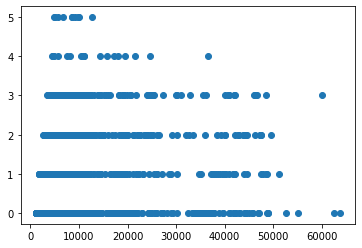

In [4]:
plt.scatter(data_train['charges'], data_train['children'])

(array([404.,   0., 217.,   0., 177.,   0., 110.,   0.,  18.,  10.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

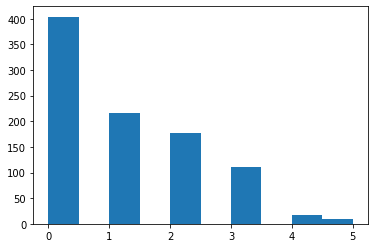

In [11]:
plt.hist(data_train['children'])

{'whiskers': [<matplotlib.lines.Line2D at 0x26a1cd89f08>,
 'caps': [<matplotlib.lines.Line2D at 0x26a1cd94d48>,
 'boxes': [<matplotlib.lines.Line2D at 0x26a1cd89ac8>],
 'medians': [<matplotlib.lines.Line2D at 0x26a1cd9ba48>],
 'fliers': [<matplotlib.lines.Line2D at 0x26a1cd9f908>],
 'means': []}

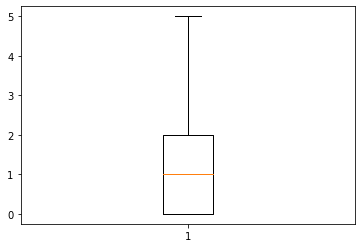

In [12]:
plt.boxplot(data_train['children'])

In [21]:
corr = stats.pearsonr(data_train['children'], data_train['charges'])
print ('coeficiente de correlacion children: ' +  str(corr[0]) + ' p-value: '+ str(corr[1]))

coeficiente de correlacion: 0.029208815698438504 p-value: 0.3720637894559578


#### Estudio de la variable *bmi*

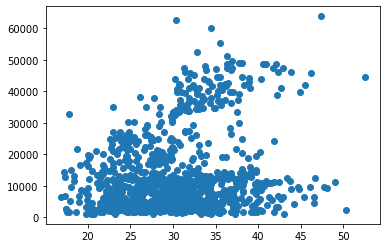

In [5]:
plt.scatter(data_train['bmi'], data_train['charges'])

(array([ 37., 101., 158., 227., 199., 120.,  58.,  23.,  10.,   3.]),
 array([16.815 , 20.3915, 23.968 , 27.5445, 31.121 , 34.6975, 38.274 ,
        41.8505, 45.427 , 49.0035, 52.58  ]),
 <a list of 10 Patch objects>)

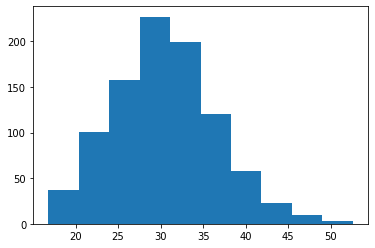

In [22]:
plt.hist(data_train['bmi'])

{'whiskers': [<matplotlib.lines.Line2D at 0x26a1ce09fc8>,
 'caps': [<matplotlib.lines.Line2D at 0x26a1ce0ddc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x26a1ce04cc8>],
 'medians': [<matplotlib.lines.Line2D at 0x26a1ce15f88>],
 'fliers': [<matplotlib.lines.Line2D at 0x26a1ce18e08>],
 'means': []}

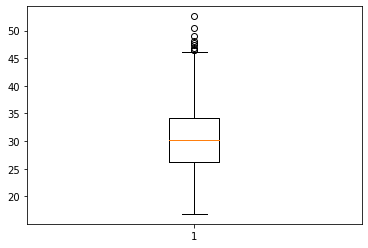

In [13]:
plt.boxplot(data_train['bmi'])

In [24]:
corr = stats.pearsonr(data_train['bmi'], data_train['charges'])
print ('coeficiente de correlacion bmi: ' +  str(corr[0]) + ' p-value: '+ str(corr[1]))

coeficiente de correlacion: 0.20140295772067424 p-value: 5.056898757056297e-10


#### Estudio de la variable *edad*

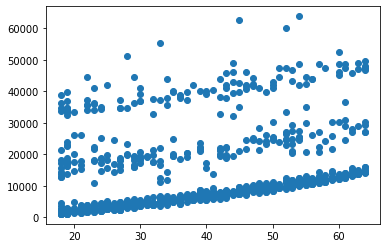

In [7]:
plt.scatter(data_train['age'], data_train['charges'])

(array([149., 102.,  80.,  92.,  68., 100., 101.,  73.,  91.,  80.]),
 array([18. , 22.6, 27.2, 31.8, 36.4, 41. , 45.6, 50.2, 54.8, 59.4, 64. ]),
 <a list of 10 Patch objects>)

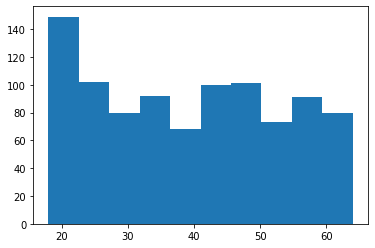

In [8]:
plt.hist(data_train['age'])

{'whiskers': [<matplotlib.lines.Line2D at 0x26a1cbe78c8>,
 'caps': [<matplotlib.lines.Line2D at 0x26a1cbed9c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x26a1cbe7308>],
 'medians': [<matplotlib.lines.Line2D at 0x26a1cbf6888>],
 'fliers': [<matplotlib.lines.Line2D at 0x26a1cbf9988>],
 'means': []}

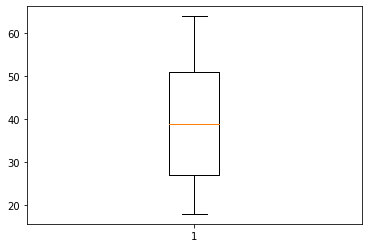

In [9]:
plt.boxplot(data_train['age'])

In [25]:
corr = stats.pearsonr(data_train['age'], data_train['charges'])
print ('coeficiente de correlacion age: ' +  str(corr[0]) + ' p-value: '+ str(corr[1]))

coeficiente de correlacion: 0.29473385463334034 p-value: 3.2481519047922746e-20


#### Estudio de la variable *charges*

(array([366., 274.,  98.,  64.,  21.,  43.,  42.,  23.,   2.,   3.]),
 array([ 1121.8739  ,  7386.729311, 13651.584722, 19916.440133,
        26181.295544, 32446.150955, 38711.006366, 44975.861777,
        51240.717188, 57505.572599, 63770.42801 ]),
 <a list of 10 Patch objects>)

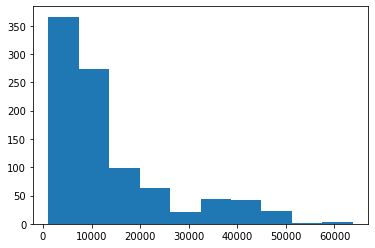

In [14]:
plt.hist(data_train['charges'])

{'whiskers': [<matplotlib.lines.Line2D at 0x26a1d4a86c8>,
 'caps': [<matplotlib.lines.Line2D at 0x26a1d4a8d48>,
 'boxes': [<matplotlib.lines.Line2D at 0x26a1d49ff08>],
 'medians': [<matplotlib.lines.Line2D at 0x26a1d4aecc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x26a1d4aedc8>],
 'means': []}

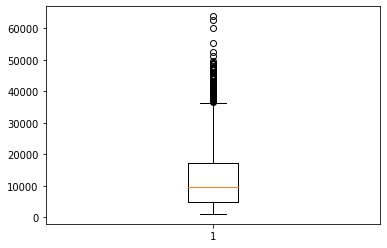

In [28]:
plt.boxplot(data_train['charges'])

## Conclusión del estudio de los datos continuos
La variable *age* presenta una relación lineal con la variable objetivo y no presenta valores atipicos como podemos apreciar. Le aplicaremos una transformación robust-scaler. 

La variable *children* según el coeficiente de pearson tiene una baja relación lineal con un p-valor > 0.05 lo que nos dice que la relación lineal no es *significativa*. Le aplicaremos una transformación min-max-scaler para establecer una escala [0,1] ya que tiene una desviación tipica pequeña.

La variables *bmi* presenta bastantes valores atipicos dentro de sus datos esto se aprecia en el box-plot lo que puede influir negativamente a la hora de aplicar algunos modelos lineales sensibles. A este le aplicaremos una transformación robust-scaler para minimizar el impacto de los valores atipicos a la hora de utilizar un modelo.

Al igual que con la variable *bmi* la variable objetivo *charges* presenta una gran cantidad de valores atipicos lo que puede llegar a dificultar el aprendizaje de los modelos lineales sensibles.

De las variables *sex*, *region*, *smoker* aun no podemos hablar ya que hay que transformarlas ya que son datos discretos de los que lo único que podemos ver es como estan distribuidos pero no podemos observar la correlación por el momento hasta que no sean transformados. Para su transformación aplicaremos la tecnica *One-Hot-Encoding* y generaremos nuevas caracteristicas que tendrán el valor 0 o 1 en función del valor original.

In [44]:
transformed_data = transform_data(data_train, True)

### Estudio de las variables discretas

#### Estudio de las variables male/female obtenidas

(array([481.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 455.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

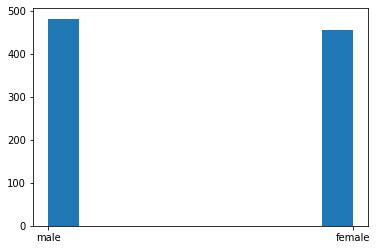

In [31]:
plt.hist(data_train['sex'])

In [35]:
corr_male = stats.pearsonr(transformed_data['male'], data_train['charges'])
corr_female = stats.pearsonr(transformed_data['female'], data_train['charges'])

print ('coeficiente de correlacion \'male\': ' +  str(corr_male[0]) + ' p-value: '+ str(corr_male[1]))
print ('coeficiente de correlacion \'female\': ' +  str(corr_female[0]) + ' p-value: '+ str(corr_female[1]))

coeficiente de correlacion 'male': 0.06246584238269505 p-value: 0.05608180759037066
coeficiente de correlacion 'female': -0.06246584238269505 p-value: 0.05608180759037066


#### Estudio de las variables smoker/non-smoker obtenidas

(array([733.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 203.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

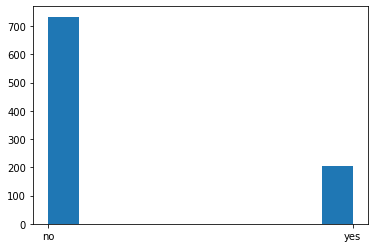

In [36]:
plt.hist(data_train['smoker'])

In [37]:
corr_smoker = stats.pearsonr(transformed_data['smoker'], data_train['charges'])
corr_non_smoker = stats.pearsonr(transformed_data['non smoker'], data_train['charges'])

print ('coeficiente de correlacion \'smoker\': ' +  str(corr_smoker[0]) + ' p-value: '+ str(corr_smoker[1]))
print ('coeficiente de correlacion \'non smoker\': ' +  str(corr_non_smoker[0]) + ' p-value: '+ str(corr_non_smoker[1]))

coeficiente de correlacion 'smoker': 0.7825954137971805 p-value: 1.857607899938705e-194
coeficiente de correlacion 'non smoker': -0.7825954137971805 p-value: 1.857607899938705e-194


#### Estudio de las variables northeast/northwest/southeast/southwest

(array([235.,   0.,   0., 219.,   0.,   0., 231.,   0.,   0., 251.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

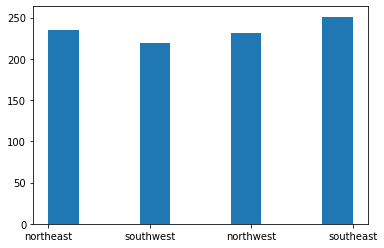

In [38]:
plt.hist(data_train['region'])

In [40]:
corr_northeast = stats.pearsonr(transformed_data['northeast'], data_train['charges'])
corr_northwest = stats.pearsonr(transformed_data['northwest'], data_train['charges'])
corr_southeast = stats.pearsonr(transformed_data['southeast'], data_train['charges'])
corr_southwest = stats.pearsonr(transformed_data['southwest'], data_train['charges'])

print ('coeficiente de correlacion \'northeast\': ' +  str(corr_northeast[0]) + ' p-value: '+ str(corr_northeast[1]))
print ('coeficiente de correlacion \'northwest\': ' +  str(corr_northwest[0]) + ' p-value: '+ str(corr_northwest[1]))
print ('coeficiente de correlacion \'southeast\': ' +  str(corr_southeast[0]) + ' p-value: '+ str(corr_southeast[1]))
print ('coeficiente de correlacion \'southwest\': ' +  str(corr_southwest[0]) + ' p-value: '+ str(corr_southwest[1]))

coeficiente de correlacion 'northeast': -0.02304434411289738 p-value: 0.4813251945689984
coeficiente de correlacion 'northwest': -0.027069504909886896 p-value: 0.4081166211679457
coeficiente de correlacion 'southeast': 0.09789141963254731 p-value: 0.002716660061808068
coeficiente de correlacion 'southwest': -0.05126316103449839 p-value: 0.1170478723850215


### Conclusion de los datos discretos
Las variables obtenidas de *sex*: *male/female* tienen un p-valor > 0.05 lo que nos dice que no son significativas en relación a la variable objetivo.

Las variables obtenidas de *smoker*: *smoker/non smoker* tienen una alta correlación con la variable objetivo, de las variables que tiene este conjunto de datos es la más significativa en relación a la variable objetivo.

Las variables obtenidas de *region*: *northeast/northwest/southeast/southwest* solo una de ellas es significativa y es la variable *southeast* en relación a la variable objetivo.

### División de los datos 

In [45]:
X = transformed_data
y = data_train['charges']

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = 43)

### Modelos y evaluación de los mismos

### Regresión lineal

#### Entrenamiento

In [46]:
regressor = LinearRegression()
regressor.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

##### Coeficientes obtenidos para cada variable

In [47]:
pd.DataFrame(data=np.expand_dims(regressor.coef_, axis=0), columns=X.columns.values)

,age,bmi,female,male,children,non smoker,smoker,northeast,northwest,southeast,southwest
0,6485.793956,2839.074544,-10.93567,10.93567,1504.184418,-11881.15685,11881.15685,250.452565,238.170207,-178.352972,-310.2698


##### Evaluación del modelo

In [48]:
y_predict = regressor.predict(X_test)

print ("MAE: ", mean_absolute_error(y_test, y_predict))
print ("MSE: ", mean_squared_error(y_test, y_predict))
print ("R2: ", regressor.score(X, y))

MAE:  4503.97955533559
MSE:  40063762.84298283
R2:  0.7497079497806778


### ElasticNet

#### Entrenamiento y evaluacion

In [116]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=15, l1_ratio=1).fit(X,y)

y_predict = elastic.predict(X_test)

print ("MAE: ", mean_absolute_error(y_test, y_predict))
print ("MSE: ", mean_squared_error(y_test, y_predict))
print ("R2: ", elastic.score(X, y))

MAE:  4512.186648221744
MSE:  40169409.87369915
R2:  0.7496370339864546


### Stochastic Gradient Descent

#### Entrenamiento y evaluacion

In [52]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(max_iter=100, random_state=43)
sgd.fit(X,y)

y_predict = sgd.predict(X_test)

print ("MAE: ", mean_absolute_error(y_test, y_predict))
print ("MSE: ", mean_squared_error(y_test, y_predict))
print ("R2: ", sgd.score(X, y))

MAE:  4516.281775874348
MSE:  40089481.09053279
R2:  0.7496806760560586


#### Ridge

#### Entrenamiento y evaluacion

In [194]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0).fit(X,y)
y_predict = ridge.predict(X_test)

print ("MAE: ", mean_absolute_error(y_test, y_predict))
print ("MSE: ", mean_squared_error(y_test, y_predict))
print ("R2: ", ridge.score(X, y))

MAE:  4529.317621702127
MSE:  41070885.06353393
R2:  0.7471719638428449


### Lasso

#### Entrenamiento y evaluacion

In [200]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1).fit(X,y)
y_predict = lasso.predict(X_test)

print ("MAE: ", mean_absolute_error(y_test, y_predict))
print ("MSE: ", mean_squared_error(y_test, y_predict))
print ("R2: ", lasso.score(X, y))


MAE:  4503.09801853709
MSE:  40069130.12565504
R2:  0.749707292821906


### Conclusiones de los modelos 
Una vez vistos los problemas que tenían las variables como la ausencia de linealidad o baja significación de algunas de ellas vemos que todos los modelos obtienen unos resultados muy similares y que no se pueden dar como del todo buenos porque para dar una predicción un resultado aproximado de un 75% no es excesivamente fiable. 

Con esos resultados decido buscar modelos no estudiados en clase que no tengan problemas a la hora de hacer una regresión en la que pueda haber problemas como la falta de linealidad.

## Modelo elegido para el problema

### Stochastic Gradient Boosting
Este modelo esta formado por un conjunto de arboles de decisión individuales entrenados de forma secuencial, de manera que cada nuevo árbol trata de mejorar los errores cometidos en los anteriores. La predicción de una nueva observación se obtiene agregando las predicciones de todos los arboles individuales que forman el modelo. 

Este modelo es capaz de seleccionar los predictores de forma automatica, no requiere de preprocesamiento de los datos continuos unicamente hay que aplicar one-hot-encoding a los datos categoricos y además no se ve muy influenciado por la presencia de outliers.

Este modelo tiene algunos problemas como:
    - Combinar muchos arboles para hacer las predicciones se pierde la interpretabilidad que tienen otros modelos.
    - Cuando se trata con predictores continuos, pierden parte de su información al categorizarla en el momento de la division de los nodos
    - No son capaces de extrapolar fuera del rango de los predictores observados en los datos de entrenamiento.
    - Si no se controlan bien los hiperparametros es muy fácil que se produzca overfitting.

### Entrenamiento y ajuste de hiperparametros
Este modelo usa algunos hiper parametros que conviene comentar:

    - n_stimators: Numero de arboles que vamos a generar. Este puede llevar a que haya overfitting en el modelo si no lo
                   ajustamos de forma correcta.
    - max_depth: Profundidad máxima que pueden alcanzar los árboles. Este al igual que n_stimators puede llevar a que haya
                 overfitting si no lo ajustamos de forma correcta.
    - subsample: Es la proporción de datos utilizados para el ajuste de cada arbol. Cuando su valor es inferior a 1 se 
                 aplica Stochastic Gradient Boosting.
    - min_samples_split: Número mínimo de observaciones que debe de tener un nodo para que pueda dividirse.
    - learning_rate: Es el factor de aprendizaje y tiene que ser siempre un numero muy pequeño ya que controla cuanto de 
                     rapido va a aprender nuestro modelo y un valor elevado conduce a que haya overfitting.
    - loss: Funcion de perdida que vamos a optimizar en este modelo. 
    - warm_start: Cuando esta a True si la siguiente predicción es peor que la anterior la desechara y se quedará 
                      con la anterior evitando así tambien que haya demasiadas iteraciones y se produzca overfitting
    - random_state: Es la semilla como en otros modelos que hemos utilizado para que los resultados sean reproducibles.

In [1]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_params = {
        'n_estimators': 500,
        'max_depth': 3,
        'subsample': 0.8,
        'min_samples_split': 20,
        'learning_rate': 0.01,
        'loss': 'ls',
        'random_state': 43,
        'warm_start': True
}

gbr = GradientBoostingRegressor(**gbr_params)
gbr.fit(X,y)

NameError: name 'X' is not defined

### Evaluación del modelo

In [ ]:
y_predict = gbr.predict(X_test)
print ("MAE: ", mean_absolute_error(y_test, y_predict))
print ("MSE: ", mean_squared_error(y_test, y_predict))
print ("R2: ", gbr.score(X, y))


data_predict = transform_data(data_test, False)
predict = gbr.predict(data_predict)

write_results_csv(predict)

In [229]:
cross_val_score(gbr, X, y, cv=5, scoring='neg_mean_error')

array([-24297308.64284927, -30244442.48246622, -24335525.25136495,
       -26233206.2077271 , -37686405.02342275])

### Conclusión final
Este modelo ha funcionado mejor para este conjunto de datos en concreto por sus facilidades a la hora de trabajar con datos atipicos y porque no presenta los mismos problemas a la hora de que sea necesaria la existencia de una relación lineal con la variable objetivo pero aunque sus resultados sean mejores que los modelos lineales es una pena que no se puedan interpretar con la misma sencillez